# Imports

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.io import wavfile
from IPython.display import Audio
import logging
import sys
from random import choices
from scipy import signal
import torch
import os
import scipy.io.wavfile
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data
from itertools import groupby
import random

logging.basicConfig(
    format='%(asctime)s [%(levelname)s] %(name)s - %(message)s',
    level=logging.DEBUG,
    datefmt='%Y-%m-%d %H:%M:%S',
    stream=sys.stdout,
)
log = logging.getLogger('')
logging.getLogger("matplotlib").setLevel(logging.INFO)
logging.getLogger("librosa").setLevel(logging.INFO)

%load_ext tensorboard

# Dataset generation

## Utils

In [192]:
def generate_sine_wave(f, sr, duration):
    x = np.arange(duration * sr)
    y = np.sin(2 * np.pi * f * x / sr)
    return y


morse_code_dict = {
    '-----': '0',
    '.----': '1',
    '..---': '2',
    '...--': '3',
    '....-': '4',
    '.....': '5',
    '-....': '6',
    '--...': '7',
    '---..': '8',
    '----.': '9',
    '.-': 'A',
    '-...': 'B',
    '-.-.': 'C',
    '-..': 'D',
    '.': 'E',
    '..-.': 'F',
    '--.': 'G',
    '....': 'H',
    '..': 'I',
    '.---': 'J',
    '-.-': 'K',
    '.-..': 'L',
    '--': 'M',
    '-.': 'N',
    '---': 'O',
    '.--.': 'P',
    '--.-': 'Q',
    '.-.': 'R',
    '...': 'S',
    '-': 'T',
    '..-': 'U',
    '...-': 'V',
    '.--': 'W',
    '-..-': 'X',
    '-.--': 'Y',
    '--..': 'Z',
}

num_tags = len(morse_code_dict)+1
tag_to_idx = {c: i + 1 for i, c in enumerate(list(morse_code_dict.values()) + [' '])}
idx_to_tag = {i + 1: c for i, c in enumerate(list(morse_code_dict.values()) + [' '])}

def find_key_by_value(dictionary, target_value):
    for key, value in dictionary.items():
        if value == target_value:
            return key
    return None


def char_to_morse(char):
    return find_key_by_value(morse_code_dict, char.upper())


def morse_char_to_signal(morse_char, dit_signal, dash_signal, dit_space_signal):
    packet = []

    for idx, v in enumerate(morse_char):
        if v == '-':
            packet = np.concatenate((packet, dash_signal))
        if v == '.':
            packet = np.concatenate((packet, dit_signal))
        if idx < len(morse_char) - 1:
            packet = np.concatenate((packet, dit_space_signal))

    return packet


def string_to_morse_signal(sentence, dit_signal, dash_signal, dit_space_signal, char_space_signal, word_space_signal):
    packet = []

    for _, c in enumerate(sentence):
        if c == ' ':
            packet = np.concatenate((packet, word_space_signal))
        else:
            char_signal = morse_char_to_signal(morse_char=char_to_morse(char=c),
                                               dit_signal=dit_signal,
                                               dash_signal=dash_signal,
                                               dit_space_signal=dit_space_signal)
            packet = np.concatenate((packet, char_signal))
            packet = np.concatenate((packet, char_space_signal))
    return packet


def apply_noise_and_channel(signal, channelResponse, SNRdb, rayleigh_dist=False):
    convolved = np.convolve(signal, channelResponse)
    signal_power = np.mean(abs(convolved ** 2))
    sigma2 = signal_power * 10 ** (-SNRdb / 10)  # calculate noise power based on signal power and SNR

    if rayleigh_dist:
        noise = np.sqrt(sigma2 / 2) * (np.random.rayleigh(*convolved.shape) + 1j * np.random.rayleigh(*convolved.shape))
    else:
        noise = np.sqrt(sigma2 / 2) * (np.random.randn(*convolved.shape) + 1j * np.random.randn(*convolved.shape))
    return convolved + noise


def save_packet_to_file(sr, packet, file_name='test', listen=False):
    packet_norm = np.int16(packet / np.max(np.abs(packet)) * 32000)
    filename = f'.//test_outputs//{file_name}.wav'
    wavfile.write(filename, sr, packet_norm)
    if listen:
        Audio(filename)


def apply_noise_to_signal(signal, SNRdb):
    signal_power = np.mean(abs(signal ** 2))
    sigma2 = signal_power * 10 ** (-SNRdb / 10)  # calculate noise power based on signal power and SNR
    noise = np.sqrt(sigma2 / 2) * (np.random.randn(*signal.shape) + 1j * np.random.randn(*signal.shape))
    return signal + noise

def apply_random_variations(sr, main_freq, dit_duration, dash_duration, variation_percent=0.1):
    """
    :param sr:
    :param main_freq:
    :param dit_duration:
    :param dash_duration:
    :param variation_percent: between 0 and 1
    :return:
    """
    rand = 1 + random.uniform(-variation_percent, variation_percent)
    dit_signal = generate_sine_wave(main_freq, sr, dit_duration * rand)

    rand = 1 + random.uniform(-variation_percent, variation_percent)
    dash_signal = generate_sine_wave(main_freq, sr, dash_duration * rand)

    rand = 1 + random.uniform(-variation_percent, variation_percent)
    dit_space_signal = np.int16(np.zeros(int(sr * dit_duration * rand)))

    rand = 1 + random.uniform(-variation_percent, variation_percent)
    char_space_signal = np.int16(np.zeros(int(sr * 3 * dit_duration * rand)))

    rand = 1 + random.uniform(-variation_percent, variation_percent)
    word_space_signal = np.int16(np.zeros(int(sr * 4 * dit_duration * rand)))

    return dit_signal, dash_signal, dit_space_signal, char_space_signal, word_space_signal


def generate_random_word(vocab, word_length):
    return ''.join(choices(list(vocab.values()) + [' '], k=word_length))

def prediction_to_str(seq):
    if not isinstance(seq, list):
        seq = seq.tolist()

    # remove duplicates
    seq = [i[0] for i in groupby(seq)]

    # remove blanks
    seq = [s for s in seq if s != 0]

    # convert to string
    seq = "".join(idx_to_tag[c] for c in seq)

    return seq

## Generator

In [255]:
class MorseGenerator:
    def __init__(self, sr=11025, base_duration=0.06, main_freq=1e3):
        # params
        self.sr = sr
        self.base_duration = base_duration
        self.main_freq = main_freq
        self.dit_duration = self.base_duration
        self.dash_duration = 3 * self.base_duration
        
        # generate base signals
        self.dit_signal = generate_sine_wave(main_freq, sr, self.dit_duration)
        self.dash_signal = generate_sine_wave(main_freq, sr, self.dash_duration)
        self.dit_space_signal = np.int16(np.zeros(int(sr * self.dit_duration)))
        self.char_space_signal = np.int16(np.zeros(int(sr * 3 * self.dit_duration)))
        self.word_space_signal = np.int16(np.zeros(int(sr * 4 * self.dit_duration)))


    def generate_morse_signal(self, s, snr, apply_noise=False, padding_start=True, padding_end=True, const_signal_length_sec=-1):
        """
        :param s: string
        :param snr: 
        :param apply_noise: 
        :return: 
        """
        # generate
        p = string_to_morse_signal(s, self.dit_signal, self.dash_signal, self.dit_space_signal, self.char_space_signal, self.word_space_signal)
        
        if padding_start:
            p = np.concatenate((self.word_space_signal, p))
            
        if padding_end:
            p = np.concatenate((p, self.word_space_signal))
        
        if const_signal_length_sec != -1:
            diff_signal = np.int16(np.zeros(int((sr * const_signal_length_sec) - len(p))))
            p = np.concatenate((p, diff_signal))
            
        if apply_noise:
            p = apply_noise_to_signal(signal=p, SNRdb=snr)
        
        # normalization
        p = np.int16(p / np.max(np.abs(p)) * 32000)
        return p


    def get_spectrogram(self, x):
        window_length = int(0.02 * self.sr)  # 20 ms windows
        _, _, sxx = signal.spectrogram(x, nperseg=window_length, noverlap=0)
        return sxx

    def get_training_sample(self, x, str):
        sxx = self.get_spectrogram(x)

        sxx = torch.from_numpy(sxx)
        sxx = sxx.permute(1, 0)
        
        y_tags = [tag_to_idx[c] for c in str]
        y_tags = torch.tensor(y_tags)

        return sxx, y_tags

## init generator

In [256]:
# params
sr = 11025
main_freq = 1e3
base_duration = 0.06
word_length = 4
snr = 5
const_signal_length_sec = 4

# Dataset size
number_of_samples = 10
directory_path = './/test_outputs'

# generator init
morse_generator = MorseGenerator(sr=sr, base_duration=base_duration, main_freq=main_freq)

## Generate 1 Example

C:\Users\Maor\AppData\Local\Temp\ipykernel_39628\76156896.py:42: ComplexWarning:

Casting complex values to real discards the imaginary part



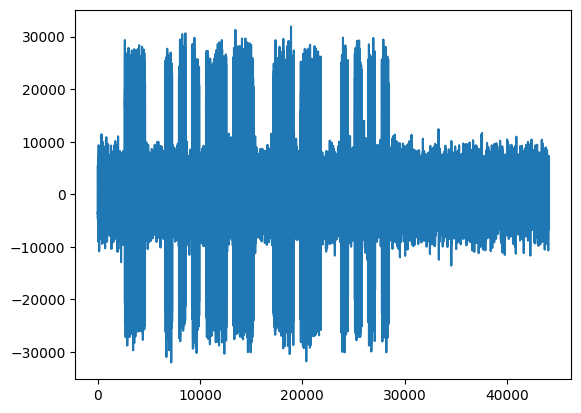

C:\Users\Maor\AppData\Local\Temp\ipykernel_39628\4247521335.py:6: ComplexWarning:

Casting complex values to real discards the imaginary part



In [221]:
random_str = generate_random_word(morse_code_dict, word_length=word_length)
s_i = morse_generator.generate_morse_signal(random_str, snr=snr, apply_noise=True, padding_start=True, padding_end=True, const_signal_length_sec=const_signal_length_sec)

plt.plot(s_i)
plt.show()
packet_norm = np.int16(packet / np.max(np.abs(packet)) * 32000)
filename = f'.//test.wav'
wavfile.write(filename, sr, packet_norm)
Audio(filename)

## Generate dataset

In [220]:
# generate samples to dict
for i in range(number_of_samples):
    # generate
    random_str = generate_random_word(morse_code_dict, word_length=word_length)
    s_i = morse_generator.generate_morse_signal(random_str, snr=snr, apply_noise=True, padding_start=True, padding_end=True, const_signal_length_sec=const_signal_length_sec)
    
    # write to file
    filename = f'{directory_path}//{random_str}.wav'
    wavfile.write(filename, morse_generator.sr, s_i)
    log.debug(f'file #{i}, word="{random_str}" has been saved to: {filename}')

2024-03-23 00:34:32 [DEBUG] root - file #0, word="4KQK" has been saved to: .//test_outputs//4KQK.wav
2024-03-23 00:34:32 [DEBUG] root - file #1, word="UJZM" has been saved to: .//test_outputs//UJZM.wav
2024-03-23 00:34:32 [DEBUG] root - file #2, word="LGME" has been saved to: .//test_outputs//LGME.wav
2024-03-23 00:34:32 [DEBUG] root - file #3, word="LA76" has been saved to: .//test_outputs//LA76.wav
2024-03-23 00:34:32 [DEBUG] root - file #4, word="MOH3" has been saved to: .//test_outputs//MOH3.wav
2024-03-23 00:34:32 [DEBUG] root - file #5, word="SWYV" has been saved to: .//test_outputs//SWYV.wav
2024-03-23 00:34:32 [DEBUG] root - file #6, word="XYKE" has been saved to: .//test_outputs//XYKE.wav
2024-03-23 00:34:32 [DEBUG] root - file #7, word="QAUV" has been saved to: .//test_outputs//QAUV.wav
2024-03-23 00:34:32 [DEBUG] root - file #8, word="XLZL" has been saved to: .//test_outputs//XLZL.wav
2024-03-23 00:34:32 [DEBUG] root - file #9, word="GO X" has been saved to: .//test_outputs/

C:\Users\Maor\AppData\Local\Temp\ipykernel_39628\76156896.py:42: ComplexWarning:

Casting complex values to real discards the imaginary part



## Load dataset
loading all files as <morse string, spectrogram>

In [257]:
directory_path = './/test_outputs'
spectrograms = []
target_strings = []

files = os.listdir(directory_path)
for filename in files:
    if os.path.isfile(os.path.join(directory_path, filename)):
        # read audio file
        _, d = scipy.io.wavfile.read(f'{directory_path}//{filename}')
        d = d.astype(np.float32)
        d /= np.max(np.abs(d))

        # extract morse word to be tokenized
        morse_str, _ = os.path.splitext(filename)
        
        # get <morse str tokens, spectrogram>
        sxx, token = morse_generator.get_training_sample(d, morse_str)
        spectrograms.append(torch.tensor(sxx))
        target_strings.append(token)
        # dataset.append(morse_generator.get_training_sample(d, morse_str))
        
dataset = TensorDataset(torch.stack(spectrograms), torch.stack(target_strings))
log.debug(f'{len(files)} files has been loaded to the dataset!')

2024-03-23 21:03:02 [DEBUG] root - 10 files has been loaded to the dataset!


C:\Users\Maor\AppData\Local\Temp\ipykernel_39628\190331490.py:19: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



# junk

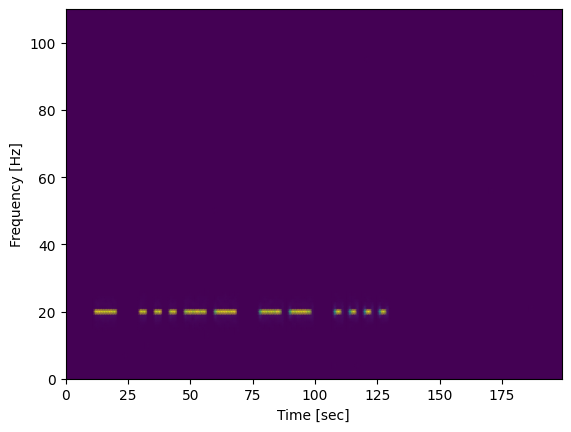

In [222]:
Sxx = morse_generator.get_spectrogram(s_i)
plt.pcolormesh(Sxx, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [224]:
Sxx.shape

(111, 200)

In [ ]:
_, data1 = scipy.io.wavfile.read('.//test_outputs//XWGM2.wav')
data1 = data1.astype(np.float32)
data1 /= np.max(np.abs(data1))
plt.plot(data1)
plt.show()

# Uses

## Morse Utils

In [172]:
MORSE_CODE_DICT = {
    'A': '.-', 'B': '-...',
    'C': '-.-.', 'D': '-..', 'E': '.',
    'F': '..-.', 'G': '--.', 'H': '....',
    'I': '..', 'J': '.---', 'K': '-.-',
    'L': '.-..', 'M': '--', 'N': '-.',
    'O': '---', 'P': '.--.', 'Q': '--.-',
    'R': '.-.', 'S': '...', 'T': '-',
    'U': '..-', 'V': '...-', 'W': '.--',
    'X': '-..-', 'Y': '-.--', 'Z': '--..',
    '1': '.----', '2': '..---', '3': '...--',
    '4': '....-', '5': '.....', '6': '-....',
    '7': '--...', '8': '---..', '9': '----.',
    '0': '-----',
    '.': '.-.-.-', ',': '--..--', '?': '..--..',
    '=': '-...-', '+': '.-.-.',
}
ALPHABET = " " + "".join(MORSE_CODE_DICT.keys())
num_tags = len(ALPHABET)

def get_spectrogram(samples, sr, nfft, nperseg, main_freq_idx=None):
    _, _, sxx = signal.spectrogram(samples, fs=sr, nfft=nfft, nperseg=nperseg, noverlap=int((0.001 * sr)))
    if main_freq_idx != None:
        sxx_filterd = sxx[list(range(main_freq_idx-2,main_freq_idx+2)), :]
        return sxx_filterd
    else:
        return sxx

## Morse Generator

In [221]:
SAMPLE_FREQ = 11025

def generate_sample(text_len=10, pitch=1000, wpm=18, noise_power=1, amplitude=100, s=None, main_freq_idx=6):
    assert pitch < SAMPLE_FREQ / 2  # Nyquist

    # Reference word is PARIS, 50 dots long
    dot = (60 / wpm) / 50 * SAMPLE_FREQ

    # Add some noise on the length of dash and dot
    def get_dot():
        scale = np.clip(np.random.normal(1, 0.2), 0.5, 2.0)
        return int(dot * scale)

    # The length of a dash is three times the length of a dot.
    def get_dash():
        scale = np.clip(np.random.normal(1, 0.2), 0.5, 2.0)
        return int(3 * dot * scale)

    # Create random string that doesn't start or end with a space
    if s is None:
        s1 = ''.join(random.choices(ALPHABET, k=text_len - 2))
        s2 = ''.join(random.choices(ALPHABET[1:], k=2))
        s = s2[0] + s1 + s2[1]

    out = []
    out.append(np.zeros(5 * get_dot()))

    # The space between two signs of the same character is equal to the length of one dot.
    # The space between two characters of the same word is three times the length of a dot.
    # The space between two words is seven times the length of a dot (or more).
    for c in s:
        if c == ' ':
            out.append(np.zeros(7 * get_dot()))
        else:
            for m in MORSE_CODE_DICT[c]:
                if m == '.':
                    out.append(np.ones(get_dot()))
                    out.append(np.zeros(get_dot()))
                elif m == '-':
                    out.append(np.ones(get_dash()))
                    out.append(np.zeros(get_dot()))

            out.append(np.zeros(2 * get_dot()))

    out.append(np.zeros(5 * get_dot()))
    out = np.hstack(out)

    # Modulatation
    t = np.arange(len(out)) / SAMPLE_FREQ
    sine = np.sin(2 * np.pi * t * pitch)
    out = sine * out

    # Add noise
    noise_power = 1e-6 * noise_power * SAMPLE_FREQ / 2
    noise = np.random.normal(scale=np.sqrt(noise_power), size=len(out))
    out = 0.5 * out + noise

    out *= amplitude / 100
    out = np.clip(out, -1, 1)

    out = out.astype(np.float32)

    spec = get_spectrogram(out, sr=SAMPLE_FREQ, nfft=64, nperseg=64, main_freq_idx=main_freq_idx)

    return out, spec, s

## Example generating 1 signal

pitch: 1000, wpm: 18, noise: 71, amplitude: 102, str: ELZ2


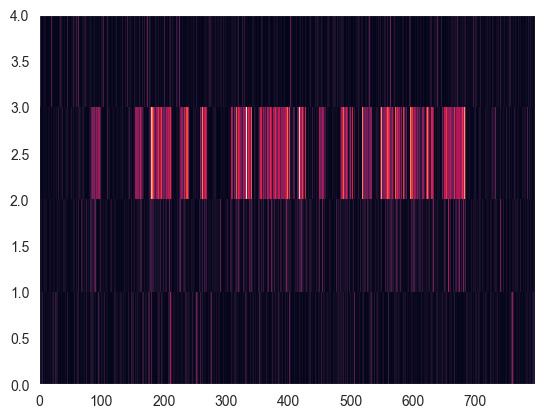

In [211]:
length = random.randrange(1, 5)
pitch = 1000
wpm = 18
main_freq_idx = 6
# pitch = random.randrange(100, 950)
# wpm = random.randrange(10, 40)
noise_power = random.randrange(0, 200)
amplitude = random.randrange(50, 150)

samples, spec, y = generate_sample(length, pitch, wpm, noise_power, amplitude, None, main_freq_idx)
samples = samples.astype(np.float32)
print(f"pitch: {pitch}, wpm: {wpm}, noise: {noise_power}, amplitude: {amplitude}, str: {y}")
plt.figure()
plt.pcolormesh(spec)
plt.show()

## Tokenizer

In [5]:
# 0: blank label
tag_to_idx = {c: i + 1 for i, c in enumerate(ALPHABET)}
idx_to_tag = {i + 1: c for i, c in enumerate(ALPHABET)}

## NN Helpers

In [6]:
def prediction_to_str(seq):
    if not isinstance(seq, list):
        seq = seq.tolist()

    seq = [i[0] for i in groupby(seq)] # remove duplicates
    seq = [s for s in seq if s != 0] # remove blanks
    seq = "".join(idx_to_tag[c] for c in seq) # convert to string
    
    return seq


def get_training_sample(*args, **kwargs):
    _, spec, y = generate_sample(*args, **kwargs)

    spec = torch.from_numpy(spec)
    spec = spec.permute(1, 0)

    y_tags = [tag_to_idx[c] for c in y]
    y_tags = torch.tensor(y_tags)

    return spec, y_tags


def collate_fn_pad(batch):
    xs, ys = zip(*batch)

    input_lengths = torch.tensor([t.shape[0] for t in xs])
    output_lengths = torch.tensor([t.shape[0] for t in ys])

    seqs = nn.utils.rnn.pad_sequence(xs, batch_first=True)
    ys = nn.utils.rnn.pad_sequence(ys, batch_first=True)

    return input_lengths, output_lengths, seqs, ys

## Model Architecture

In [219]:
class Net(nn.Module):
    def __init__(self, num_tags, spectrogram_size):
        super(Net, self).__init__()

        num_tags = num_tags + 1  # 0: blank
        hidden_dim = 256
        lstm_dim1 = 256

        self.dense1 = nn.Linear(spectrogram_size, hidden_dim)
        self.dense2 = nn.Linear(hidden_dim, hidden_dim)
        self.dense3 = nn.Linear(hidden_dim, hidden_dim)
        self.dense4 = nn.Linear(hidden_dim, lstm_dim1)
        self.lstm1 = nn.LSTM(lstm_dim1, lstm_dim1, batch_first=True)
        self.dense5 = nn.Linear(lstm_dim1, num_tags)

    def forward(self, x):
        x = F.relu(self.dense1(x))
        x = F.relu(self.dense2(x))
        x = F.relu(self.dense3(x))
        x = F.relu(self.dense4(x))
        x, _ = self.lstm1(x)
        x = self.dense5(x)
        x = F.log_softmax(x, dim=2)
        return x

    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)


class Dataset(data.Dataset):
    def __init__(self, number_of_samples=1024):
        self.length = number_of_samples
        
    def __len__(self):
        return self.length

    def __getitem__(self, index):
        length = random.randrange(1, 5)
        pitch = 1000
        wpm = 18
        main_freq_idx = 6
        noise_power = random.randrange(0, 200)
        amplitude = random.randrange(50, 150)
        
        return get_training_sample(length, pitch, wpm, noise_power, amplitude, None, main_freq_idx)

## Training loop
launch tensorboard with CLI 
tensorboard --logdir C:/Users/Maor/Desktop/dev/tensorboard/morse-dl/runs

In [ ]:
tf_board_log_dir_path = "C:/Users/Maor/Desktop/dev/tensorboard/morse-dl/runs" # path without hebrew unicode chars
batch_size = 64
spectrogram_size = generate_sample()[1].shape[0]

device = torch.device("cuda")
writer = SummaryWriter(tf_board_log_dir_path)

# Set up trainer & evaluator
model = Net(num_tags, spectrogram_size).to(device)
print("Number of params", model.count_parameters())

# Lower learning rate to 1e-4 after about 1500 epochs
optimizer = optim.Adam(model.parameters(), lr=1e-3)
ctc_loss = nn.CTCLoss()

train_loader = torch.utils.data.DataLoader(
    Dataset(number_of_samples=1024),
    batch_size=batch_size,
    collate_fn=collate_fn_pad,
)

random.seed(0)

epoch = 360
epochs = epoch + 700
losses = []

# Resume training
if epoch != 0:
    model.load_state_dict(torch.load(f"models/{epoch:06}.pt", map_location=device))
    print(f'Model has been loaded from prev state of epoch: {epoch}')

model.train()
while epoch < epochs:
    i = 0
    for (input_lengths, output_lengths, x, y) in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = model(x)
        m = torch.argmax(y_pred[0], 1)
        y_pred = y_pred.permute(1, 0, 2)

        loss = ctc_loss(y_pred, y, input_lengths, output_lengths)
        loss.backward()
        optimizer.step()
        i += 1

    writer.add_scalar("training/loss", loss.item(), epoch)
    if epoch % 10 == 0:
        torch.save(model.state_dict(), f"models/{epoch:06}.pt")

    losses.append(loss.item())
    print(f'Epoch #{epoch}| target: {prediction_to_str(y[0])}, pred: {prediction_to_str(m)}, loss: {loss.item()}')
    epoch += 1

Number of params 736043
Model has been loaded from prev state of epoch: 360
Epoch #360| target: 9X, pred: 5N, loss: 4.104963779449463
Epoch #361| target: OKR0, pred: 8., loss: 4.129741191864014
Epoch #362| target: ?=, pred: 7, loss: 4.166772842407227
Epoch #363| target: AY, pred: 6J, loss: 4.0761518478393555
Epoch #364| target: ,N1, pred: QY, loss: 4.065909385681152
Epoch #365| target: KC, pred: ,N, loss: 4.096238136291504
Epoch #366| target: C2D, pred: ,6, loss: 4.056150436401367
Epoch #367| target: I., pred: ,F, loss: 4.073970794677734
Epoch #368| target: 6P1, pred: Z=, loss: 4.113176345825195
Epoch #369| target: SGQ, pred: =, loss: 4.098601341247559
Epoch #370| target: P9, pred: Q5, loss: 4.093518257141113
Epoch #371| target: FD?I, pred: ,C, loss: 4.081343650817871
Epoch #372| target: K6, pred: ,, loss: 4.099030494689941
Epoch #373| target: +Y3, pred: ,S, loss: 4.0438456535339355
Epoch #374| target: CE+, pred: XL, loss: 4.090047836303711
Epoch #375| target: Y7N, pred: X?, loss: 4.09

## Visualize

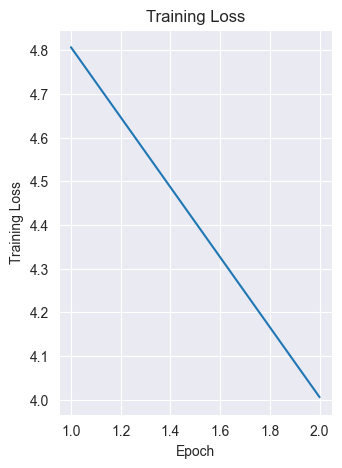

In [28]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
plt.plot(range(1, len(losses) + 1), losses)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss')
plt.show()

## Example of tensorboard add images

In [43]:
from torchvision.utils import make_grid

for i, image_tensor in enumerate([torch.tensor(spec), torch.tensor(spec)]):
    img_grid = make_grid(image_tensor, nrow=8)  # Show 8 images per row
    writer.add_image(f"Training data", img_grid, i)

# Approaches

## LSTM + RNN

### Dataset

In [184]:
class SpectrogramTagDataset(data.Dataset):
    """
    PyTorch Dataset class for spectrogram and tag data.
  
    Args:
        data: A list of tuples where each tuple is (<spectrogram>, <y_tags>).
            <spectrogram> should be a tensor representing the spectrogram.
            <y_tags> should be a string containing the tokenized tags.
    """
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        """
        Retrieves a data sample at the specified index.
    
        Args:
            idx: The index of the data sample to retrieve.
    
        Returns:
            A tuple containing the spectrogram tensor and the tokenized tags string.
        """
        spectrogram, y_tags = self.data[idx]
        return spectrogram, y_tags

### Model Architecture

In [275]:
class Net(nn.Module):
    def __init__(self, num_tags, spectrogram_size):
        super(Net, self).__init__()

        hidden_dim = 256
        lstm_dim1 = 256

        self.dense1 = nn.Linear(spectrogram_size, hidden_dim)
        self.dense2 = nn.Linear(hidden_dim, hidden_dim)
        self.dense3 = nn.Linear(hidden_dim, hidden_dim)
        self.dense4 = nn.Linear(hidden_dim, lstm_dim1)
        self.lstm1 = nn.LSTM(lstm_dim1, lstm_dim1, batch_first=True)
        self.dense5 = nn.Linear(lstm_dim1, num_tags+1)

    def forward(self, x):
        batch_size = x.size(0)
        x = x.view(batch_size, -1)

        x = F.relu(self.dense1(x))
        x = F.relu(self.dense2(x))
        x = F.relu(self.dense3(x))
        x = F.relu(self.dense4(x))
        x, _ = self.lstm1(x)
        x = self.dense5(x.squeeze(1))
        # x = F.log_softmax(x, dim=2)
        x = x.log_softmax(1)
        return x

    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

### Utils

In [163]:
def collate_fn_pad(batch):
    xs, ys = zip(*batch)

    input_lengths = torch.tensor([t.shape[0] for t in xs])
    output_lengths = torch.tensor([t.shape[0] for t in ys])

    seqs = nn.utils.rnn.pad_sequence(xs, batch_first=True)
    ys = nn.utils.rnn.pad_sequence(ys, batch_first=True)

    return input_lengths, output_lengths, seqs, ys

### Training

In [282]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Params
batch_size = 1
spectrogram_size = dataset[0][0].shape[0] * dataset[0][0].shape[1] 
epochs = 50

# Set up trainer & evaluator
model = Net(num_tags, spectrogram_size).to(device)
print("Number of params", model.count_parameters())

optimizer = optim.Adam(model.parameters(), lr=1e-3)
# ctc_loss = nn.CTCLoss()
criterion = nn.CTCLoss(blank=num_tags, zero_infinity=True)
train_loader = torch.utils.data.DataLoader(
    # SpectrogramTagDataset(dataset),
    dataset,
    batch_size=batch_size,
    shuffle=True,
    # collate_fn=collate_fn_pad,
)

random.seed(0)
epoch = 0
# 
# # Resume training
# if epoch != 0:
#     model.load_state_dict(torch.load(f"models/{epoch:06}.pt", map_location=device))

model.train()
while epoch < epochs:
    # for (input_lengths, output_lengths, x, y) in train_loader:
    for spectrograms, targets in train_loader:
        spectrograms, targets = spectrograms.to(device), targets.to(device)

        optimizer.zero_grad()
        y_pred = model(spectrograms)

        # m = torch.argmax(y_pred[0], 1)
        # y_pred = y_pred.permute(1, 0, 2)

        input_lengths = torch.tensor([targets.size(0)] * spectrograms.size(0), dtype=torch.long)
        target_lengths = torch.full(size=(targets.size(0),), fill_value=targets.size(1), dtype=torch.long)

        # input_lengths = torch.tensor([t.shape[0] for t in spectrograms])
        # target_lengths = torch.tensor([t.shape[0] for t in targets])

        # input_lengths = torch.full(size=(y_pred.size(0),), fill_value=y_pred.size(1), dtype=torch.long)
        # target_lengths = torch.full(size=(targets.size(0),), fill_value=targets.size(1), dtype=torch.long)
        loss = criterion(y_pred, targets, input_lengths, target_lengths)
        # loss = ctc_loss(y_pred, y, input_lengths, output_lengths)

        loss.backward()
        optimizer.step()

    # if epoch % 10 == 0:
    #     torch.save(model.state_dict(), f"models/{epoch:06}.pt")
    print(f'Epoch: {epoch + 1}, Train Loss: {loss.item()}')
    # print(prediction_to_str(y_pred[0]))
    # print(prediction_to_str(m))
    epoch += 1

Number of params 6416934
Epoch: 1, Train Loss: 0.0
Epoch: 2, Train Loss: 0.0
Epoch: 3, Train Loss: 0.0
Epoch: 4, Train Loss: 0.0
Epoch: 5, Train Loss: 0.0
Epoch: 6, Train Loss: 0.0
Epoch: 7, Train Loss: 0.0
Epoch: 8, Train Loss: 0.0
Epoch: 9, Train Loss: 0.0
Epoch: 10, Train Loss: 0.0
Epoch: 11, Train Loss: 0.0
Epoch: 12, Train Loss: 0.0
Epoch: 13, Train Loss: 0.0
Epoch: 14, Train Loss: 0.0
Epoch: 15, Train Loss: 0.0
Epoch: 16, Train Loss: 0.0
Epoch: 17, Train Loss: 0.0
Epoch: 18, Train Loss: 0.0
Epoch: 19, Train Loss: 0.0
Epoch: 20, Train Loss: 0.0
Epoch: 21, Train Loss: 0.0
Epoch: 22, Train Loss: 0.0
Epoch: 23, Train Loss: 0.0
Epoch: 24, Train Loss: 0.0
Epoch: 25, Train Loss: 0.0
Epoch: 26, Train Loss: 0.0
Epoch: 27, Train Loss: 0.0
Epoch: 28, Train Loss: 0.0
Epoch: 29, Train Loss: 0.0
Epoch: 30, Train Loss: 0.0
Epoch: 31, Train Loss: 0.0
Epoch: 32, Train Loss: 0.0
Epoch: 33, Train Loss: 0.0
Epoch: 34, Train Loss: 0.0
Epoch: 35, Train Loss: 0.0
Epoch: 36, Train Loss: 0.0
Epoch: 37, T